In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
# Compute the parent directory (project root)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
# Insert the project root into sys.path if it's not already there
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
           
import numpy as np
from registry import get_registry
from dual_datasets import VIGORDataset
from utils import get_data_transforms, process_data
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from qualitative_utils import get_images, get_heatmap_array, show_ground, get_heatmap, show_image, get_distance_array
from tqdm import tqdm
from functools import partial

/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-p

In [5]:
dataset_root='/work/vita/qngo/VIGOR'
area = 'samearea'
training = False # test dataset
pos_only = True
transform_grd, transform_sat = get_data_transforms()

vigor = VIGORDataset(dataset_root, 
                 split=area, 
                 train=training, 
                 pos_only=pos_only, 
                 transform=(transform_grd, transform_sat),
                 use_osm_tiles=True)

loaded data pikle
osm tiles loaded for NewYork
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/NewYork/satellite_list.txt 23279
loaded data pikle
osm tiles loaded for Seattle
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Seattle/satellite_list.txt 44055
loaded data pikle
osm tiles loaded for SanFrancisco
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/SanFrancisco/satellite_list.txt 68310
loaded data pikle
osm tiles loaded for Chicago
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Chicago/satellite_list.txt 90618
Sat loaded, data size:90618
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/NewYork/same_area_balanced_test.txt 13884
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Seattle/same_area_balanced_test.txt 25759
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/SanFrancisco/same_area_balanced_test.txt 39866
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Chicago/same_area_balanced_test.txt

In [6]:
def load_distances(experiment_name, base_path):
    return np.load(os.path.join(base_path, experiment_name, "distance_test.npy"))

base_path = '/work/vita/qngo/test_results'
experiment_name = 'hard_select_fusion'
distances = load_distances(experiment_name, base_path)

In [7]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_wrapper = get_registry('hard_patch_DAF')('hard_patch_DAF', device)
experiment_name = 'hard_patch_DAF'

def load_model(model_wrapper, base_model_path: str, model_name: str, epoch: int):
    epoch = str(epoch)
    model_path = os.path.join(base_model_path, model_name, epoch, "model.pt")
    model_wrapper.load_model(model_path)

epoch='3'
base_model_path = "/work/vita/qngo/models/VIGOR/"
load_model(model_wrapper, base_model_path, experiment_name, epoch=epoch)
model_wrapper.set_model_to_eval()

distance_array = []

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/mmcv/ops/multi_scale_deform_attn.py:231: UserWarning: You'd better set embed_dims in MultiScaleDeformAttention to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(
/home/qngo/semester-project-vita/CCVPE/wrappers/hardPatchDAFWrapper.py:298: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by 

In [8]:
def deconstruct_weights(weights):
    weights_s = weights.squeeze(0)
    weights_volume = weights_s[0] # 16 - 1
    weights_15 = weights_s[1] # 16 - 1
    weights_10 = weights_s[2:6] # 32 - 2x2=4
    weights_4 = weights_s[6:22] # 64 - 4x4=16
    weights_2 = weights_s[22:86] # 128 - 8x8=64
    weights_0 = weights_s[86:342] # 256  - 16x16=256
    return weights_volume, weights_15, weights_10, weights_4, weights_2, weights_0

In [9]:
import seaborn as sns

def plot_weights(weights):
    weights_volume, weights_15, weights_10, weights_4, weights_2, weights_0 = deconstruct_weights(weights)
    fig, axs = plt.subplots(6,1, figsize=(20,20))
    w0 = weights_0[:,1].reshape((16,16))
    sns.heatmap(w0, vmin=0, vmax=1, ax=axs[0], square=True)
    axs[0].set_title(f"16x16  (1:sat, 0:osm)? mean : {np.mean(w0):.3f}")
    w2 = weights_2[:.1].reshape((8, 8))
    sns.heatmap(w2, vmin=0, vmax=1,ax=axs[1], square=True)
    axs[1].set_title(f'8x8 mean: {np.mean(w2):.3f}')
    w4 = weights_4[:,1].reshape((4,4))
    sns.heatmap(w4, vmin=0, vmax=1,ax=axs[2], square=True)
    axs[2].set_title(f'4x4 mean: {np.mean(w4):.3f}')
    w10 = weights_10[:,1].reshape((2,2))
    sns.heatmap(w10, vmin=0, vmax=1,ax=axs[3], square=True)
    axs[3].set_title(f'2x2 mean: {np.mean(w10):.3f}')
    w15 = weights_15[1].reshape((1,1))
    sns.heatmap(w15, vmin=0, vmax=1,ax=axs[4], square=True)
    axs[4].set_title(f'1x1 mean: {np.mean(w15):.3f}')
    wvol = weights_volume[1].reshape((1,1))
    sns.heatmap(wvol, vmin=0, vmax=1,ax=axs[5], square=True)
    axs[5].set_title(f'1x1 volume mean: {np.mean(wvol):.3f}')

In [10]:
from torchvision.transforms.v2 import GaussianNoise
from qualitative_utils import show_image_subplot

def gaussian_noise(x, scale=0.0):
    return GaussianNoise(sigma=scale, clip=False)(x)

torch.Size([1, 3, 320, 640])


AttributeError: 'list' object has no attribute 'cpu'

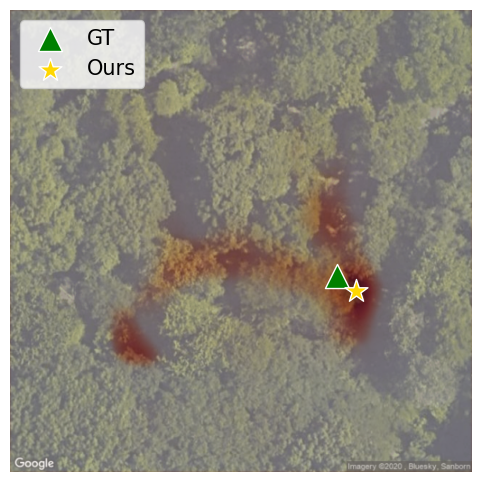

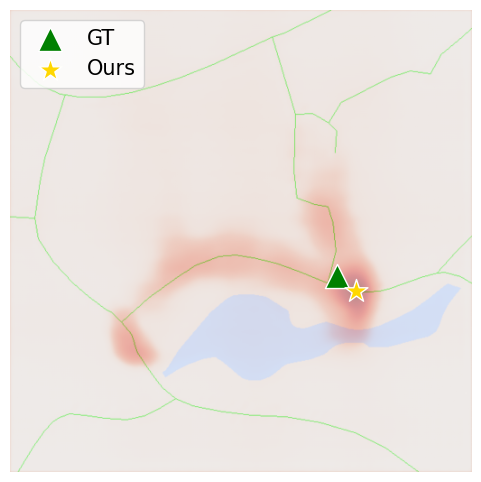

In [11]:
idx = 679
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

scale = 0.0
osm_n = gaussian_noise(osm, scale=scale)
heatmap, output = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
# print('weights ', weights)
plot_weights(weights.cpu().detach().numpy())

torch.Size([1, 3, 320, 640])


AttributeError: 'list' object has no attribute 'cpu'

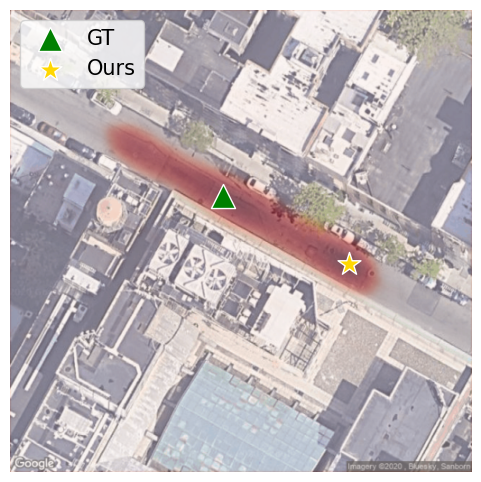

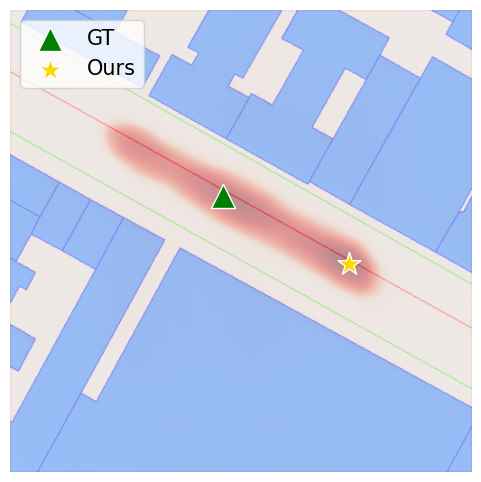

In [12]:
idx = 26
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

scale = 0.0
osm_n = gaussian_noise(osm, scale=scale)
heatmap, output = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
plot_weights(weights.cpu().detach().numpy())

In [ ]:
idx = 39888
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

scale = 0.0
osm_n = gaussian_noise(osm, scale=scale)
heatmap, output = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
plot_weights(weights.cpu().detach().numpy())

In [ ]:
idx = 894
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)
fig, axs = plt.subplots(3,2, figsize=(10,10))

heatmap = infer_p(osm, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
show_ground(grd_p)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 0, 0, axs, 'sat 0 noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 0, 1, axs, 'osm 0 noise')

scale = .5
sat_n = gaussian_noise(sat, scale=scale)
heatmap = infer_p(osm, sat_n)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
sat_p = gaussian_noise(sat_p, scale=scale)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 1, 0, axs, f'sat {scale} noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 1, 1, axs, f'osm 0 noise')

scale = .5
osm_n = gaussian_noise(sat, scale=scale)
heatmap = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 2, 0, axs, f'sat 0 noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 2, 1, axs, f'osm {scale} noise')

distance_array[idx]

In [ ]:
idx = 679
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)
fig, axs = plt.subplots(3,2, figsize=(10,10))

heatmap = infer_p(osm, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
show_ground(grd_p)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 0, 0, axs, 'sat 0 noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 0, 1, axs, 'osm 0 noise')

scale = .5
sat_n = gaussian_noise(sat, scale=scale)
heatmap = infer_p(osm, sat_n)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
sat_p = gaussian_noise(sat_p, scale=scale)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 1, 0, axs, f'sat {scale} noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 1, 1, axs, f'osm 0 noise')

scale = .5
osm_n = gaussian_noise(sat, scale=scale)
heatmap = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 2, 0, axs, f'sat 0 noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 2, 1, axs, f'osm {scale} noise')

distance_array[idx]

In [ ]:
idx = 40524
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)
fig, axs = plt.subplots(3,2, figsize=(10,10))

heatmap = infer_p(osm, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
show_ground(grd_p)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 0, 0, axs, 'sat 0 noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 0, 1, axs, 'osm 0 noise')

scale = .5
sat_n = gaussian_noise(sat, scale=scale)
heatmap = infer_p(osm, sat_n)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
sat_p = gaussian_noise(sat_p, scale=scale)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 1, 0, axs, f'sat {scale} noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 1, 1, axs, f'osm 0 noise')

scale = .5
osm_n = gaussian_noise(sat, scale=scale)
heatmap = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image_subplot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 2, 0, axs, f'sat 0 noise')
show_image_subplot(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, 2, 1, axs, f'osm {scale} noise')

distance_array[idx]

In [ ]:
idx = 40524
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

scale = 0.0
osm_n = gaussian_noise(osm, scale=scale)
heatmap, output = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
plot_weights(weights.cpu().detach().numpy())

In [ ]:
idx = 40524
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

scale = 0.5
osm_n = gaussian_noise(osm, scale=scale)
heatmap, output = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
plot_weights(weights.cpu().detach().numpy())

In [ ]:
idx = 40524
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

osm_n = torch.zeros_like(osm)
heatmap, output = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
osm_p = gaussian_noise(osm_p, scale=scale)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
plot_weights(weights.cpu().detach().numpy())

In [3]:
idx = 40524
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

sat_n = torch.zeros_like(sat)
heatmap, output = infer_p(osm, sat_n)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
scale = 0
osm_p = gaussian_noise(osm_p, scale=scale)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
plot_weights(weights.cpu().detach().numpy())

NameError: name 'vigor' is not defined

torch.Size([1, 3, 320, 640])


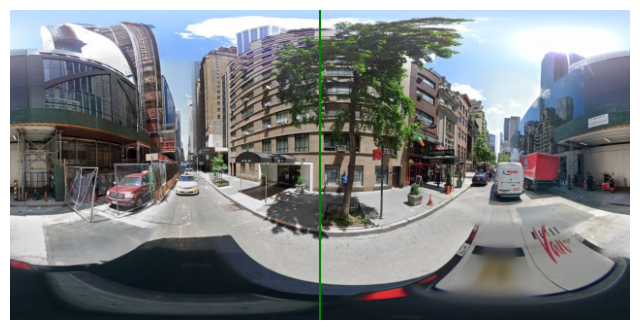

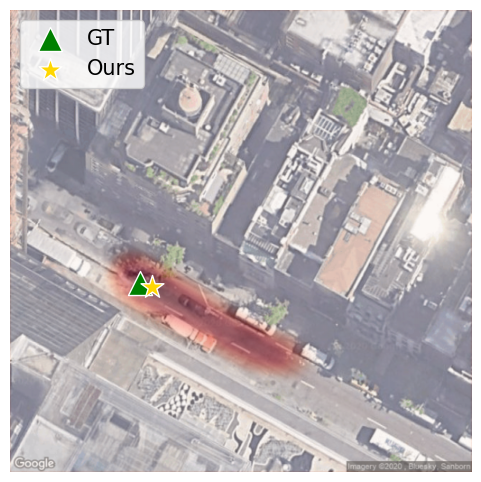

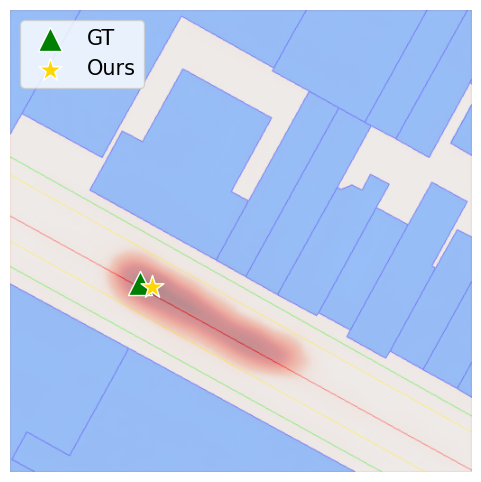

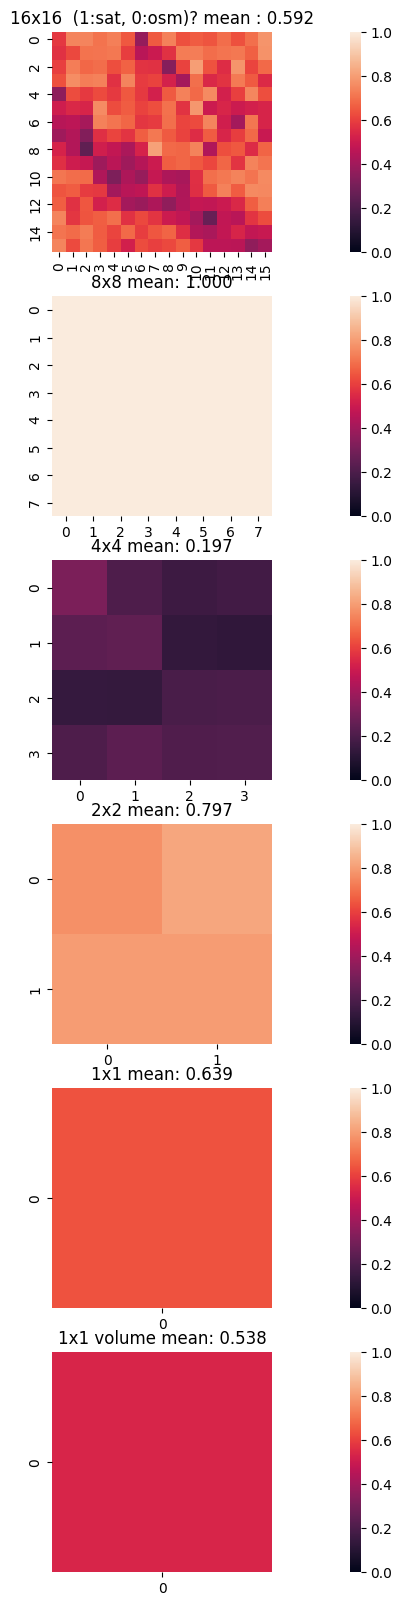

In [63]:
idx += 1
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

sat_n = sat
heatmap, output = infer_p(osm, sat_n)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)
scale = 0
osm_p = gaussian_noise(osm_p, scale=scale)
show_ground(grd_p)
show_image(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
plot_weights(weights.cpu().detach().numpy())